In [ ]:
!pip install quandl -q

In [ ]:
import pandas as pd
import quandl, datetime
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

#DESCARGA Y PREPARACIÓN DE DATOS

En esta celda se conecta con la API de Quandl utilizando una clave personal y se descarga la tabla `WIKI/PRICES` correspondiente al ticker 'GOOGL', es decir, las cotizaciones históricas de las acciones de Google. Luego se convierte la columna `date` en el índice del DataFrame para facilitar las operaciones temporales.

Esto es esencial para trabajar con series temporales, ya que usar la fecha como índice nos permite ordenar, graficar o hacer predicciones a futuro de forma más natural.


In [ ]:
quandl.ApiConfig.api_key = "rnUVi5ikhP226HiLvh6p"
df = quandl.get_table('WIKI/PRICES', ticker='GOOGL')
df.set_index(['date'], inplace = True, drop=True)

#📊 ANÁLISIS DESCRIPTIVO INICIAL

Aquí se usa `describe()` para obtener un resumen estadístico de todas las columnas numéricas del DataFrame. Esto incluye métricas como promedio (`mean`), desviación estándar (`std`), mínimos, máximos y percentiles.

Es útil para:
- Identificar valores atípicos (outliers)
- Comprender la escala de cada variable
- Detectar columnas con valores constantes (como `split_ratio`)

In [ ]:
df.describe()

,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
count,3424.000000,3424.000000,3424.000000,3424.000000,3.424000e+03,3424.000000,3424.0,3424.000000,3424.000000,3424.000000,3424.000000,3.424000e+03
mean,596.602610,602.045438,590.571710,596.352862,7.818568e+06,0.165880,1.0,409.221461,412.786556,405.227809,409.057885,7.818568e+06
std,226.989782,227.783310,225.846581,226.896692,8.248211e+06,9.706436,0.0,257.844081,259.366718,255.981628,257.773495,8.248211e+06
min,99.090000,101.740000,95.960000,100.010000,5.211410e+05,0.000000,1.0,49.698414,51.027517,48.128568,50.159839,5.211410e+05
25%,461.157500,465.392500,456.065000,461.205000,2.430647e+06,0.000000,1.0,231.292728,233.416785,228.738594,231.316552,2.430647e+06
50%,565.120000,569.599950,559.860000,564.940000,5.076200e+06,0.000000,1.0,300.174109,302.496277,297.909618,300.264387,5.076200e+06
75%,735.627500,740.850000,728.680025,733.262500,1.020910e+07,0.000000,1.0,561.178118,565.000000,556.673036,561.200000,1.020910e+07
max,1226.800000,1228.880000,1218.600000,1220.170000,8.215110e+07,567.971668,1.0,1188.000000,1198.000000,1184.060000,1187.560000,8.215110e+07


In [ ]:
df.tail()

,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,,
2004-08-25,GOOGL,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0
2004-08-24,GOOGL,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-23,GOOGL,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-20,GOOGL,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-19,GOOGL,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0


#🧮 SELECCIÓN DE VARIABLES RELEVANTES

Aquí se crea un nuevo DataFrame llamado `work` que contiene solo las columnas ajustadas más relevantes para el análisis de precios:
- `adj_open`, `adj_high`, `adj_low`, `adj_close`: precios ajustados por dividendos y splits.
- `adj_volume`: volumen de transacciones, también ajustado.

Se excluyen otras columnas irrelevantes para simplificar el modelo y enfocarse en las variables más representativas del comportamiento del precio real.


In [ ]:
work = df[['adj_open','adj_high','adj_low','adj_close','adj_volume']]

#📈 CÁLCULO DE VOLATILIDAD INTRADÍA (%)

Se agrega una nueva columna llamada `hl_pct` que mide el cambio porcentual entre el precio más alto del día y el precio de cierre ajustado:

`(adj_high - adj_close) / adj_close * 100`

Esto nos da una medida de cuánta volatilidad hubo en el día. Días con valores altos en `hl_pct` pueden indicar incertidumbre o cambios de tendencia. Es una **feature ingenierizada** que se usará como input del modelo de predicción.


In [ ]:
work['hl_pct']=((work['adj_high']-work['adj_close']) / work['adj_close']) * 100.00

<ipython-input-7-e5882ab201cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work['hl_pct']=((work['adj_high']-work['adj_close']) / work['adj_close']) * 100.00


#📉 CÁLCULO DE VARIACIÓN DIARIA DEL PRECIO (%)

Aquí se calcula la columna `pct_change`, que mide la variación porcentual entre el precio de apertura y el precio de cierre ajustado:

`(adj_close - adj_open) / adj_open * 100`

Esta métrica indica si el precio subió o bajó durante el día. Es una variable predictiva muy común en análisis bursátil porque resume la tendencia del día en un solo valor.


In [ ]:
work['pct_change']=((work['adj_close']-work['adj_open']) / work['adj_open']) * 100.00

<ipython-input-8-ac7d7a4adcff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work['pct_change']=((work['adj_close']-work['adj_open']) / work['adj_open']) * 100.00


#🧹 SELECCIÓN FINAL DE VARIABLES

Después de crear las nuevas columnas (`hl_pct` y `pct_change`), aquí se seleccionan únicamente las variables relevantes para el modelo de predicción:
- `adj_close`: variable base que también será nuestra etiqueta futura.
- `hl_pct`, `pct_change`: características generadas.
- `adj_volume`: volumen ajustado.

Esto simplifica el modelo y evita el uso de información redundante o irrelevante.

In [ ]:
work = work[['adj_close','hl_pct','pct_change','adj_volume']]

In [ ]:
work= work.sort_values(by='date', ascending=True) # Los muestro del más viejo al más nuevo para verlos como el profe del curso.

work.head()

,adj_close,hl_pct,pct_change,adj_volume
date,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0
2004-08-20,54.322689,0.710922,7.227007,22834300.0
2004-08-23,54.869377,3.729433,-1.227880,18256100.0
2004-08-24,52.597363,6.417469,-5.726357,15247300.0
2004-08-25,53.164113,1.886792,1.183658,9188600.0


#🎯 DEFINICIÓN DE LA VARIABLE A PREDECIR Y RELLENO DE NULOS

Aquí se define `forecast_col`, la columna que queremos predecir: en este caso `adj_close`. Luego se reemplazan los posibles valores nulos con `-99999` para evitar errores al entrenar el modelo.

Esta sustitución extrema también le señala al modelo que esos valores son anómalos y no deberían influir.

✅ ¿Por qué usar -99999?
-99999 es un marcador numérico extremo, un valor que está completamente fuera del rango realista de los datos financieros (por ejemplo, nunca habrá un precio de acción negativo tan grande).

Se utiliza por dos motivos principales:

1. Evita errores en el entrenamiento del modelo
Muchos algoritmos de machine learning (por ejemplo, LinearRegression, SVM, etc. en scikit-learn) no aceptan valores faltantes (NaN) como entrada. Si no los manejas, obtienes errores como:

ValueError: Input contains NaN, infinity or a value too large for dtype('float64')

Al usar -99999, estás reemplazando NaN por un valor numérico válido (aunque artificial), lo que permite que el modelo se entrene sin fallar.

2. Funciona como una bandera "visible" para el modelo
El modelo notará que ese valor está extremadamente lejos de la media, y si está bien entrenado, aprenderá a ignorarlo o reducir su impacto en la predicción.

⚠️ Pero ojo: esto es una técnica de conveniencia, no ideal
Usar -99999 puede introducir ruido o sesgos si:

El modelo no logra diferenciarlo de un valor legítimo (por ejemplo, en escalas grandes).

No normalizas los datos antes.

Lo usas en producción sin filtrar las predicciones generadas desde esos valores.

In [ ]:
forecast_col = 'adj_close'
work.fillna(-99999, inplace=True)

#🔮 DEFINICIÓN DEL HORIZONTE DE PREDICCIÓN

Se calcula cuántos días hacia el futuro queremos hacer la predicción. Usamos el 1% del tamaño total del DataFrame como ventana de predicción (`forecast_out`).

Esta es una forma proporcional y adaptable de definir el horizonte temporal sin fijar una cantidad arbitraria.


In [ ]:
forecast_out = int(math.ceil(0.01*len(df)))

#🏷️ CREACIÓN DE LA COLUMNA OBJETIVO (`label`)

Se crea una nueva columna llamada `label` que contiene el valor futuro del precio de cierre ajustado (`adj_close`), desplazado hacia arriba `forecast_out` días.

Así, cada fila queda emparejada con el precio futuro que se desea predecir: esto transforma el problema en una tarea de aprendizaje supervisado.

In [ ]:
work['label'] = work[forecast_col].shift(-forecast_out)

In [ ]:
work.head()

,adj_close,hl_pct,pct_change,adj_volume,label
date,,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0,69.078238
2004-08-20,54.322689,0.710922,7.227007,22834300.0,67.839414
2004-08-23,54.869377,3.729433,-1.227880,18256100.0,68.912727
2004-08-24,52.597363,6.417469,-5.726357,15247300.0,70.668146
2004-08-25,53.164113,1.886792,1.183658,9188600.0,71.219849


#🧠 ENTRENAMIENTO DEL MODELO DE MACHINE LEARNING
En esta sección se preparan los datos para entrenar el modelo de predicción. Se siguen los pasos clásicos de un pipeline de Machine Learning supervisado:

Separación de variables (X e Y)
Se crea X con todas las columnas excepto 'label', que es nuestra variable objetivo. Luego se normaliza (scaling) con preprocessing.scale para asegurar que todas las features tengan igual peso. Esto es especialmente importante para algoritmos sensibles a escalas como SVM o regresión.

División temporal para predicción futura
Separamos los últimos forecast_out registros en X_lately, que son las observaciones más recientes que queremos predecir. Estas no tienen label, ya que pertenecen al futuro. El resto (X) se queda para entrenamiento del modelo.

Limpieza de datos
Se eliminan las filas con NaN (por ejemplo, aquellas a las que se les asignó label desplazado hacia el futuro pero no tenían suficiente información).

Definición de Y
Se extrae la variable objetivo (label) como Y, lista para usarse en el entrenamiento supervisado.

Con esta preparación, los datos están listos para alimentar algoritmos como regresión lineal, SVM o redes neuronales para predecir precios futuros de acciones.

##🔍 ¿Por qué se usa fillna(-99999) y luego dropna()?
En el flujo de preparación de datos se usan dos estrategias distintas para manejar valores faltantes, en momentos diferentes del pipeline, cada una con una función específica:

🧼 fillna(-99999) → antes de crear la columna label
Este paso reemplaza los NaN originales que puedan estar en las columnas de entrada (adj_open, adj_close, adj_volume, etc.). Es una forma rápida de evitar que el modelo falle por valores faltantes durante el preprocesamiento o el entrenamiento. El valor -99999 actúa como un marcador extremo que el modelo puede aprender a ignorar si está bien entrenado.

📌 Objetivo: Evitar errores por datos incompletos en las features antes de crear nuevas variables o escalar los datos.

🧹 dropna() → después de crear la columna label
Cuando se crea la variable objetivo label desplazando la columna adj_close hacia el futuro (shift(-forecast_out)), se generan nuevas filas sin valor (NaN) al final del DataFrame. Esto ocurre porque no hay datos futuros disponibles para completar esas etiquetas.

📌 Objetivo: Eliminar las filas que no tienen label (es decir, sin valor a predecir), ya que no se pueden usar para entrenar el modelo supervisado.

| Acción           | ¿Cuándo?                 | ¿Qué valores limpia?             | ¿Por qué se hace?                          |
| ---------------- | ------------------------ | -------------------------------- | ------------------------------------------ |
| `fillna(-99999)` | Antes de crear `label`   | `NaN` en las columnas de entrada | Prevenir errores al entrenar el modelo     |
| `dropna()`       | Después de crear `label` | `NaN` en la columna `label`      | Eliminar filas sin valor objetivo (target) |

In [ ]:
X = np.array(work.drop(['label'], axis=1))

In [ ]:
X = preprocessing.scale(X) # Scaling

In [ ]:
X_lately = X[-forecast_out:]

In [ ]:
X = X[:-forecast_out]

In [ ]:
work.dropna(inplace=True)

In [ ]:
Y = np.array(work['label'])

# 🤖 Entrenamiento del modelo — Regresión lineal
En esta sección se implementa el primer modelo de predicción utilizando regresión lineal, una técnica estadística simple pero efectiva para modelar relaciones entre variables continuas.

Primero, se dividen los datos en un conjunto de entrenamiento y otro de prueba (80% y 20%, respectivamente). Esto permite evaluar la capacidad del modelo para generalizar a nuevos datos sin haberlos visto previamente.

A continuación, se entrena el modelo con los datos históricos y se calcula su precisión mediante el coeficiente R². El resultado (≈0.97) indica que el modelo explica muy bien la variabilidad en los datos de prueba, lo que sugiere que es una buena primera aproximación.

Con el modelo entrenado, se generan predicciones para los valores futuros más recientes (según el horizonte `forecast_out`). Estas predicciones se integran al DataFrame con fechas proyectadas, permitiendo visualizar cómo se comportarían los precios en los próximos días.

La gráfica final permite comparar visualmente el comportamiento histórico (`adj_close`) con la trayectoria esperada (`Forecast`), lo cual es fundamental para validar la utilidad del modelo en escenarios reales de análisis financiero.

Este modelo servirá como referencia base para comparar el rendimiento de algoritmos más complejos en etapas posteriores.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
clf = LinearRegression()

In [ ]:
clf.fit(X_train,Y_train)

LinearRegression()

##SALVAR EL CLASIFICADOR PARA NO VOLVERLO A PROCESARLO, QUIZÁS SÓLO UNA VEZ AL MES.

In [ ]:
'''
with open ('linearregression.pickle','wb') as f:
  pickle.dump(clf, f)

pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)
'''

"\nwith open ('linearregression.pickle','wb') as f:\n  pickle.dump(clf, f)\n\npickle_in = open('linearregression.pickle','rb')\nclf = pickle.load(pickle_in)\n"

In [ ]:
accuracy = clf.score(X_test,Y_test) #Accuracy Test
accuracy

0.9767957447131217

In [ ]:
forecast_set = clf.predict(X_lately)

In [ ]:
print(forecast_set, accuracy, forecast_out)

[1101.88356395 1071.70564834 1018.11570374 1060.57310794 1072.61266844
 1072.94792939 1091.64877693 1110.85925746 1113.86985271 1121.91607106
 1131.00489344 1128.58429044 1148.28094779 1163.91360045 1135.08909739
 1121.39977056 1086.90780054 1102.79203426 1113.7007999  1120.71103254
 1134.61984314 1149.26710173 1180.77088497 1185.00593273 1156.4764268
 1167.94643335 1169.75837415 1152.36865375 1117.83135271 1114.43469742
 1112.12975444 1069.08563366 1041.20739151 1072.57192596 1019.69393175] 0.9767957447131217 35


In [ ]:
work['Forecast'] = np.nan

In [ ]:
last_date = work.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [ ]:
for pred in forecast_set:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  work.loc[next_date] = [np.nan for _ in range(len(work.columns)-1)] + [pred]

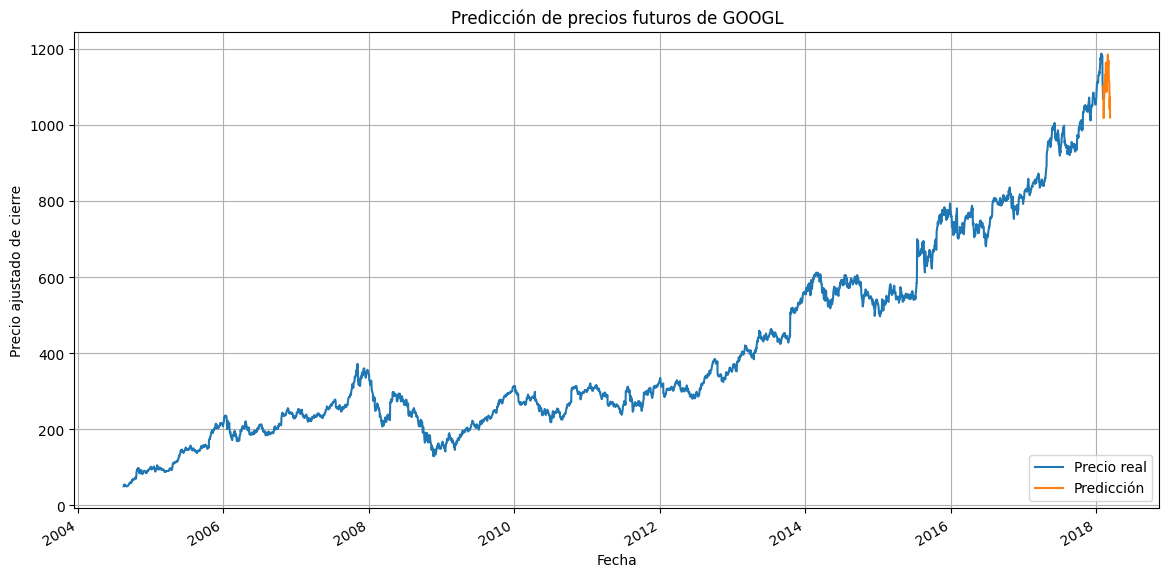

In [ ]:
plt.figure(figsize=(14, 7))  # más grande
work['adj_close'].plot(label='Precio real')
work['Forecast'].plot(label='Predicción')
plt.legend(loc='lower right')
plt.xlabel('Fecha')
plt.ylabel('Precio ajustado de cierre')
plt.title('Predicción de precios futuros de GOOGL')
plt.grid(True)
plt.show()

#📈 Segundo modelo — Máquinas de Soporte Vectorial (SVM)
En esta sección se entrena un modelo de regresión basado en SVM (Support Vector Machine), específicamente utilizando SVR, la variante para problemas de regresión.

Al igual que en el modelo anterior, se utiliza el conjunto de entrenamiento (X_train, Y_train) para ajustar el modelo, y luego se evalúa su precisión en los datos de prueba mediante el coeficiente R².

El resultado obtenido es aproximadamente 0.80, lo que indica una capacidad predictiva aceptable, pero inferior al modelo de regresión lineal, que había alcanzado un R² de ≈0.97.

⚖️ ¿Por qué el modelo de regresión lineal fue más eficiente?
Simplicidad del patrón de datos: La serie temporal de precios ajustados de Google presenta una tendencia ascendente relativamente estable, que puede modelarse eficazmente con una relación lineal.

Rapidez computacional: La regresión lineal entrena de forma casi instantánea, mientras que SVM, especialmente con kernels por defecto, puede ser más costosa en tiempo y memoria.

Overfitting en SVM sin ajustar hiperparámetros: SVR() usa por defecto un kernel RBF, que puede adaptarse demasiado a patrones locales y no generalizar bien si no se ajustan parámetros como C, gamma, o epsilon.

✅ Conclusión
Aunque SVM es un algoritmo poderoso para relaciones no lineales, en este caso la regresión lineal no solo es más precisa, sino también más eficiente, lo que la convierte en una mejor opción base para este tipo de serie temporal financiera. Posteriormente, se podría optimizar SVM con validación cruzada o comparar con modelos aún más robustos como Random Forest o LSTM.

In [ ]:
clf_svm = svm.SVR()

In [ ]:
clf_svm.fit(X_train,Y_train)

SVR()

In [ ]:
clf_svm.score(X_test,Y_test)

0.8149446054373641